# Transfer learning Fine-tuning on the `train_dataset`

This notebook demonstrates how a pre-trained CNN can be fine-tuned using randomly selected train splits. Here, we'll demonstrate fine-tuning a pre-trained CNN on the medical image classification task. In this example, fine-tuning serves to update the CNN to new measurement parameters. This code illustrates the procedure described in the `3.Materials and methods`. 

Copyright (C) 2023, Zhao Bingqiang, All Rights Reserved

Email: zbqherb@163.com

2023-07-02

## Import Libs

In [1]:
import time
import os
import wandb
import random

import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## Image data preprocessing

In [2]:
# COVID-19 CT
train_transform = transforms.Compose([transforms.RandomResizedCrop(512),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))])

test_transform = transforms.Compose([transforms.Resize(1000),
                                     transforms.CenterCrop(512),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])

## Load image dataset `data_split`

In [3]:
dataset_dir = 'data_split'
train_path = os.path.join(dataset_dir, 'train')
test_path = os.path.join(dataset_dir, 'val')
print('train_dataset Path', train_path)
print('test_dataset Path', test_path)

# Load train_dataset
train_dataset = datasets.ImageFolder(train_path, train_transform)
# Load test_dataset
test_dataset = datasets.ImageFolder(test_path, test_transform)

print('train_dataset number', len(train_dataset))
print('train_dataset class number', len(train_dataset.classes))
print('train_dataset class name', train_dataset.classes)

print('test_dataset number', len(test_dataset))
print('test_dataset class number', len(test_dataset.classes))
print('test_dataset class name', test_dataset.classes)

train_dataset Path data_split\train
test_dataset Path data_split\val
train_dataset number 13682
train_dataset class number 3
train_dataset class name ['CAP', 'COVID', 'NonCOVID']
test_dataset number 3419
test_dataset class number 3
test_dataset class name ['CAP', 'COVID', 'NonCOVID']


## Class and Index mapping

In [4]:
# Mapping：Class to Index
class_to_idx = train_dataset.class_to_idx
# Mapping：Index to Class 
idx_to_labels = {y:x for x,y in train_dataset.class_to_idx.items()}
# Save mapping files
np.save('table/idx_to_labels.npy', idx_to_labels)
np.save('table/labels_to_idx.npy', class_to_idx)

print(class_to_idx)
print(idx_to_labels)

{'CAP': 0, 'COVID': 1, 'NonCOVID': 2}
{0: 'CAP', 1: 'COVID', 2: 'NonCOVID'}


## Define DataLoader

In [38]:
BATCH_SIZE = 32

# train_dataset DataLoader
train_loader = DataLoader(train_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = True,
                          num_workers = 4
                         )

# test_dataset DataLoader
test_loader = DataLoader(test_dataset,
                         batch_size = BATCH_SIZE,
                         shuffle = False,
                         num_workers = 4
                        )

## Visualize the image and annotation of a batch

torch.Size([64, 3, 512, 512])
tensor([1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 0, 0, 1, 0, 2, 1, 1, 1, 2, 2, 1, 1, 0,
        2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 0, 1, 1, 2, 1, 1, 1, 2, 2, 0, 0, 2,
        0, 1, 2, 1, 2, 2, 0, 1, 2, 1, 1, 2, 1, 1, 1, 2])


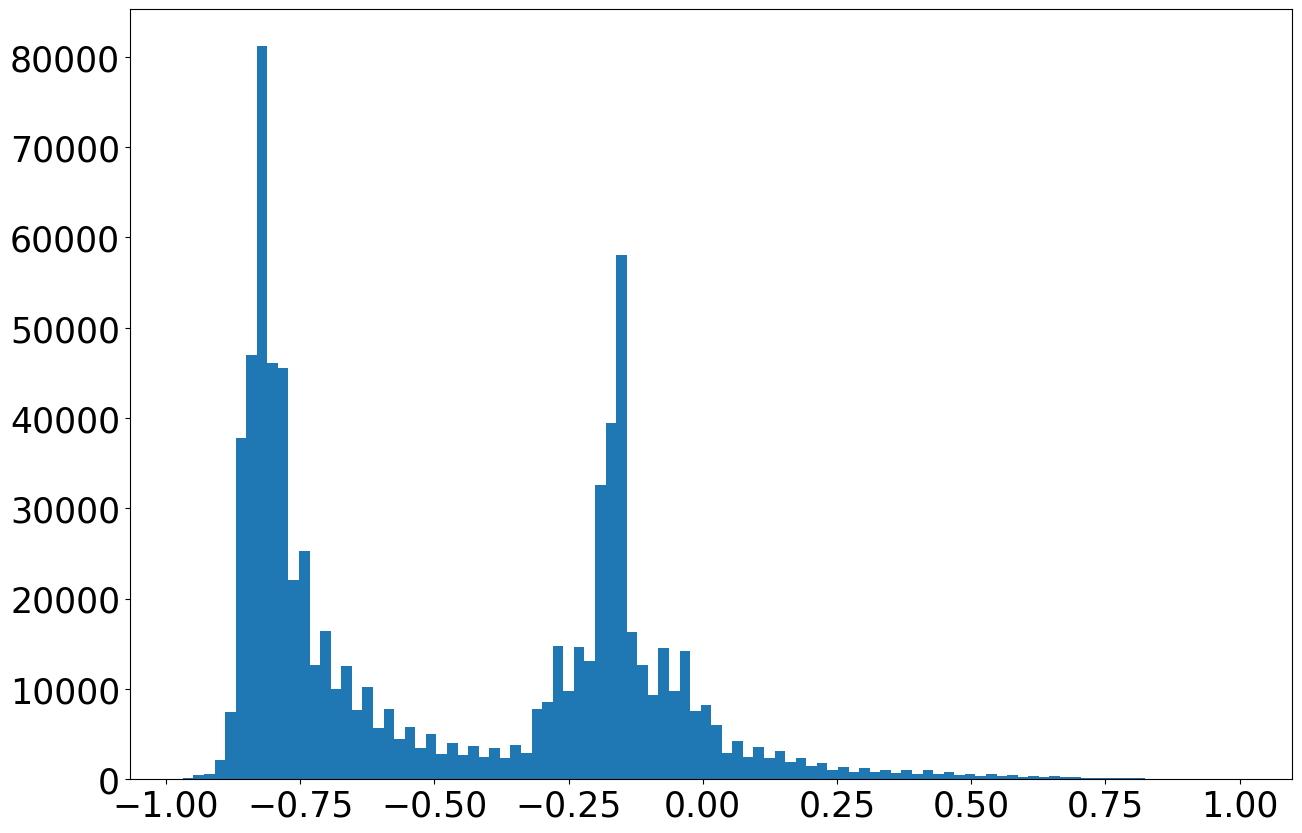

In [39]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels)

# Tensor to np.array
images = images.numpy()
plt.figure(figsize = (15,10))
plt.hist(images[10].flatten(), bins = 100)
plt.tick_params(labelsize = 25)
plt.savefig('figure/hist.tif', dpi = 300, bbox_inches = 'tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


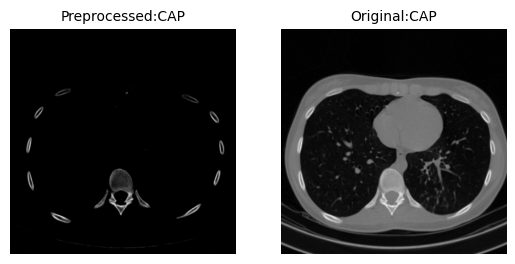

In [55]:
# Preprocessed images in the batch 
idx = 1
label = labels[idx].item()
# Preprocessed image
plt.subplot(121)
plt.imshow(images[idx].transpose((1,2,0)))
plt.axis('off')
plt.title('Preprocessed:'+ idx_to_labels[label], fontsize = 10)

# Original image
plt.subplot(122)
mean = np.array((0.5,))
std = np.array((0.5,))
# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.225])

plt.imshow(np.clip(images[idx].transpose((1,2,0)) * std + mean, 0, 1))
plt.axis('off')
plt.title('Original:'+ idx_to_labels[label], fontsize = 10)
plt.savefig('figure/image visualization2.tif', dpi = 300, bbox_inches = 'tight')

## Transfer learning fine-tuning options

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

Now we set up a ResNet CNN and load weights that previously trained for the `ImageNet`.

In [56]:
n_class = len(train_dataset.classes)

### 1. Fine-tuning fully connected layer only

In [57]:
# # Load pre_trained image classification model
# model = models.resnet18(pretrained = True) 
# # New layer default (requires_grad = True)
# model.fc = nn.Linear(model.fc.in_features, n_class)
# optimizer = optim.Adam(model.fc.parameters())

# print(model.fc)

### 2. Fine-tunning all layers

In [58]:
model = models.resnet18(pretrained = True)
model.fc = nn.Linear(model.fc.in_features, n_class)
optimizer = optim.Adam(model.parameters())

print(model.fc)

Linear(in_features=512, out_features=3, bias=True)


### 3. Initialize all model weights randomly and train all layers from scratch

In [59]:
# # Only the model structure is loaded, not the pre-training weight parameters
# model = models.resnet18(pretrained=False) 
# model.fc = nn.Linear(model.fc.in_features, n_class)
# optimizer = optim.Adam(model.parameters())

## Model training Parameters

In [60]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 

EPOCHS = 100

lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 50, gamma = 0.1)

## Function: Train on the `train_dataset`

In [61]:
def train_one_batch(images, labels):
    
    '''
    Train a batch, returns the Training Log of the current batch
    '''
    
    images = images.to(device)
    labels = labels.to(device)
    
    # Forward propagation
    outputs = model(images) 
    # Calculate the average cross-entropy loss function value 
    # of each sample in the current batch
    loss = criterion(outputs, labels) 
    
    # Back propagation, optimize and update the weight
    optimizer.zero_grad() # gradient to zero
    loss.backward() # Back propagation
    optimizer.step() # Update parameters
    
    # Gets the label ID and predicted ID for the current batch
    # Gets the predicted ID for all images in the current batch
    _, preds = torch.max(outputs, 1) 
    preds = preds.cpu().numpy()
    loss = loss.detach().cpu().numpy()
    outputs = outputs.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    
    log_train = {}
    log_train['epoch'] = epoch
    log_train['batch'] = batch_idx
    # Classification evaluation index on train_dataset
    log_train['train_loss'] = loss
    log_train['train_accuracy'] = accuracy_score(labels, preds)
    log_train['train_precision'] = precision_score(labels, preds, average = 'macro')
    log_train['train_recall'] = recall_score(labels, preds, average = 'macro')
    log_train['train_f1-score'] = f1_score(labels, preds, average = 'macro')
    
    return log_train

## Function: Evaluate on the `test_dataset`

In [62]:
def evaluate_testset():
    '''
    Evaluate the test_dataset, returns the Test log of current epoch
    '''

    loss_list = []
    labels_list = []
    preds_list = []
    
    with torch.no_grad():
        for images, labels in test_loader: # Generate a batch of data and annotations
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images) # forward prediction

            # Obtain the label and predicted ID for the test_dataset
            # Gets the predicted ID for all images in the current batch
            _, preds = torch.max(outputs, 1) 
            preds = preds.cpu().numpy()
            # Calculate the average cross-entropy loss function value 
            # of each sample in the current batch via logit
            loss = criterion(outputs, labels) 
            loss = loss.detach().cpu().numpy()
            outputs = outputs.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()

            loss_list.append(loss)
            labels_list.extend(labels)
            preds_list.extend(preds)
        
    log_test = {}
    log_test['epoch'] = epoch
    
    # Classification evaluation index on test_dataset
    log_test['test_loss'] = np.mean(loss_list)
    log_test['test_accuracy'] = accuracy_score(labels_list, preds_list)
    log_test['test_precision'] = precision_score(labels_list, preds_list, average = 'macro')
    log_test['test_recall'] = recall_score(labels_list, preds_list, average = 'macro')
    log_test['test_f1-score'] = f1_score(labels_list, preds_list, average = 'macro')
    
    return log_test

## Log recoed before training starts

In [63]:
epoch = 0
batch_idx = 0
best_test_accuracy = 0

# log_train - train_dataset
df_train_log = pd.DataFrame()
log_train = {}
log_train['epoch'] = 0
log_train['batch'] = 0
images, labels = next(iter(train_loader))
log_train.update(train_one_batch(images, labels))
df_train_log = df_train_log._append(log_train, ignore_index = True)

df_train_log

,epoch,batch,train_loss,train_accuracy,train_precision,train_recall,train_f1-score
0,0,0,1.0907118,0.34375,0.236111,0.333333,0.243819


In [64]:
# log_train - test_dataset
df_test_log = pd.DataFrame()
log_test = {}
log_test['epoch'] = 0
log_test.update(evaluate_testset())
df_test_log = df_test_log._append(log_test, ignore_index = True)

df_test_log

,epoch,test_loss,test_accuracy,test_precision,test_recall,test_f1-score
0,0.0,1.19641,0.3852,0.322114,0.324869,0.301625


## wandb visualization

In [65]:
# wandb.init(project = 'COVID', name = time.strftime('%m%d%H%M%S'))

## Train start

In [66]:
for epoch in range(1, EPOCHS+1):
    
    print(f'{datetime.now()}, Epoch {epoch}/{EPOCHS}')
    
    ## Train phase
    model.train()
    for images, labels in tqdm(train_loader): 
        batch_idx += 1
        log_train = train_one_batch(images, labels)
        df_train_log = df_train_log._append(log_train, ignore_index = True)
#         wandb.log(log_train)
        
    lr_scheduler.step()

    ## Test phase
    model.eval()
    log_test = evaluate_testset()
    df_test_log = df_test_log._append(log_test, ignore_index = True)
#     wandb.log(log_test)
    
    # Save the latest best model file
    if log_test['test_accuracy'] > best_test_accuracy: 
        # Delete old best model files (if any)
        old_best_checkpoint_path = 'checkpoint/best-{:.3f}.pth'.format(best_test_accuracy)
        if os.path.exists(old_best_checkpoint_path):
            os.remove(old_best_checkpoint_path)
        # Save the new best model file
        best_test_accuracy = log_test['test_accuracy']
        new_best_checkpoint_path = 'checkpoint/best-{:.3f}.pth'.format(log_test['test_accuracy'])
        torch.save(model, new_best_checkpoint_path)
        print('save best model', 'checkpoint/best-{:.3f}.pth'.format(best_test_accuracy))
            

df_train_log.to_csv('table/Train Log-train_dataset.csv', index = False)
df_test_log.to_csv('table/Train Log-test_dataset.csv', index = False)

2023-07-11 06:04:18.608203, Epoch 1/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


save best model checkpoint/best-0.300.pth
2023-07-11 06:07:01.708143, Epoch 2/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


save best model checkpoint/best-0.819.pth
2023-07-11 06:09:44.326975, Epoch 3/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 06:12:27.531855, Epoch 4/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


save best model checkpoint/best-0.836.pth
2023-07-11 06:15:10.748866, Epoch 5/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


save best model checkpoint/best-0.857.pth
2023-07-11 06:17:53.893076, Epoch 6/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 06:20:37.291042, Epoch 7/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


save best model checkpoint/best-0.898.pth
2023-07-11 06:23:20.455995, Epoch 8/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 06:26:03.501095, Epoch 9/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:20<00:00,  3.04it/s]


2023-07-11 06:28:45.839942, Epoch 10/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


save best model checkpoint/best-0.904.pth
2023-07-11 06:31:28.930890, Epoch 11/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:20<00:00,  3.04it/s]


2023-07-11 06:34:11.807897, Epoch 12/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:20<00:00,  3.04it/s]


2023-07-11 06:36:53.983671, Epoch 13/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 06:39:37.106901, Epoch 14/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


save best model checkpoint/best-0.911.pth
2023-07-11 06:42:20.606673, Epoch 15/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


save best model checkpoint/best-0.925.pth
2023-07-11 06:45:04.061092, Epoch 16/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:20<00:00,  3.04it/s]


2023-07-11 06:47:46.618230, Epoch 17/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 06:50:29.276260, Epoch 18/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


save best model checkpoint/best-0.931.pth
2023-07-11 06:53:12.456391, Epoch 19/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 06:55:55.546431, Epoch 20/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 06:58:38.659765, Epoch 21/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 07:01:21.587456, Epoch 22/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 07:04:04.467883, Epoch 23/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 07:06:47.824325, Epoch 24/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 07:09:30.883486, Epoch 25/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


save best model checkpoint/best-0.937.pth
2023-07-11 07:12:14.523714, Epoch 26/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 07:14:57.385041, Epoch 27/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:20<00:00,  3.04it/s]


save best model checkpoint/best-0.943.pth
2023-07-11 07:17:39.527090, Epoch 28/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:20<00:00,  3.04it/s]


2023-07-11 07:20:22.048122, Epoch 29/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 07:23:05.777198, Epoch 30/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 07:25:49.067314, Epoch 31/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 07:28:31.593860, Epoch 32/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:20<00:00,  3.04it/s]


2023-07-11 07:31:14.275833, Epoch 33/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 07:33:57.491780, Epoch 34/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


save best model checkpoint/best-0.943.pth
2023-07-11 07:36:40.149209, Epoch 35/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 07:39:23.132719, Epoch 36/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:20<00:00,  3.04it/s]


2023-07-11 07:42:05.912450, Epoch 37/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 07:44:48.630340, Epoch 38/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:20<00:00,  3.04it/s]


2023-07-11 07:47:30.968697, Epoch 39/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 07:50:14.529524, Epoch 40/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 07:52:57.833799, Epoch 41/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:22<00:00,  3.01it/s]


2023-07-11 07:55:41.840130, Epoch 42/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 07:58:24.686529, Epoch 43/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


save best model checkpoint/best-0.944.pth
2023-07-11 08:01:07.569937, Epoch 44/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 08:03:50.487539, Epoch 45/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 08:06:34.046140, Epoch 46/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


save best model checkpoint/best-0.958.pth
2023-07-11 08:09:16.976904, Epoch 47/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 08:12:00.006872, Epoch 48/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 08:14:43.059240, Epoch 49/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:20<00:00,  3.04it/s]


2023-07-11 08:17:25.615314, Epoch 50/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 08:20:08.962662, Epoch 51/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


save best model checkpoint/best-0.963.pth
2023-07-11 08:22:52.360824, Epoch 52/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


save best model checkpoint/best-0.966.pth
2023-07-11 08:25:35.307362, Epoch 53/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 08:28:18.845552, Epoch 54/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:22<00:00,  3.01it/s]


save best model checkpoint/best-0.968.pth
2023-07-11 08:31:02.471118, Epoch 55/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 08:33:45.262444, Epoch 56/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 08:36:28.122775, Epoch 57/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 08:39:11.613497, Epoch 58/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 08:41:54.308638, Epoch 59/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 08:44:38.096695, Epoch 60/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:20<00:00,  3.04it/s]


2023-07-11 08:47:20.350246, Epoch 61/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


save best model checkpoint/best-0.968.pth
2023-07-11 08:50:03.936601, Epoch 62/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 08:52:47.806028, Epoch 63/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


save best model checkpoint/best-0.970.pth
2023-07-11 08:55:31.121005, Epoch 64/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 08:58:14.783483, Epoch 65/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 09:00:57.787115, Epoch 66/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 09:03:40.540900, Epoch 67/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 09:06:23.785134, Epoch 68/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 09:09:06.993845, Epoch 69/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:20<00:00,  3.04it/s]


2023-07-11 09:11:49.943779, Epoch 70/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 09:14:33.040444, Epoch 71/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 09:17:16.161756, Epoch 72/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 09:19:59.450023, Epoch 73/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


save best model checkpoint/best-0.970.pth
2023-07-11 09:22:42.771506, Epoch 74/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 09:25:25.685903, Epoch 75/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 09:28:08.409560, Epoch 76/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.03it/s]


2023-07-11 09:30:51.789403, Epoch 77/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 09:33:35.143511, Epoch 78/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 09:36:18.873993, Epoch 79/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 09:39:02.244935, Epoch 80/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 09:41:45.537035, Epoch 81/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.01it/s]


2023-07-11 09:44:33.777784, Epoch 82/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 09:47:17.220293, Epoch 83/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 09:50:00.613572, Epoch 84/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 09:52:43.976904, Epoch 85/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 09:55:27.029181, Epoch 86/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.02it/s]


2023-07-11 09:58:10.380881, Epoch 87/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:22<00:00,  3.00it/s]


2023-07-11 10:00:54.833273, Epoch 88/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:22<00:00,  3.01it/s]


2023-07-11 10:03:39.066737, Epoch 89/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:22<00:00,  3.00it/s]


save best model checkpoint/best-0.971.pth
2023-07-11 10:06:23.545548, Epoch 90/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:22<00:00,  3.01it/s]


2023-07-11 10:09:07.324848, Epoch 91/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:22<00:00,  3.00it/s]


2023-07-11 10:11:51.704741, Epoch 92/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:23<00:00,  2.99it/s]


2023-07-11 10:14:36.770118, Epoch 93/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:22<00:00,  3.01it/s]


2023-07-11 10:17:20.742674, Epoch 94/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:21<00:00,  3.01it/s]


2023-07-11 10:20:04.313109, Epoch 95/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:22<00:00,  3.00it/s]


2023-07-11 10:22:49.202284, Epoch 96/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:22<00:00,  3.01it/s]


save best model checkpoint/best-0.971.pth
2023-07-11 10:25:33.239783, Epoch 97/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:22<00:00,  3.00it/s]


2023-07-11 10:28:18.088757, Epoch 98/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:22<00:00,  2.99it/s]


2023-07-11 10:31:02.974130, Epoch 99/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:22<00:00,  3.00it/s]


2023-07-11 10:33:47.492298, Epoch 100/100


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [02:22<00:00,  3.00it/s]


## Evaluate on `test_dataset`

In [67]:
model = torch.load('checkpoint/best-{:.3f}.pth'.format(best_test_accuracy))

model.eval()
print(evaluate_testset())

{'epoch': 100, 'test_loss': 0.11337616, 'test_accuracy': 0.9713366481427318, 'test_precision': 0.9732157816758958, 'test_recall': 0.9752822999614951, 'test_f1-score': 0.9741922176544479}


## Visualize Train Log

In [68]:
df_train = pd.read_csv('table/Train Log-train_dataset.csv')
df_test = pd.read_csv('table/Train Log-test_dataset.csv')

In [69]:
df_train

,epoch,batch,train_loss,train_accuracy,train_precision,train_recall,train_f1-score
0,0,0,1.090712,0.343750,0.236111,0.333333,0.243819
1,1,1,0.963550,0.562500,0.617521,0.696078,0.495726
2,1,2,1.577197,0.437500,0.414815,0.378788,0.394253
3,1,3,1.217352,0.687500,0.476651,0.527451,0.495614
4,1,4,0.791840,0.687500,0.848485,0.603175,0.591402
...,...,...,...,...,...,...,...
42796,100,42796,0.076561,0.968750,0.976190,0.933333,0.950617
42797,100,42797,0.110476,0.968750,0.976190,0.977778,0.976160
42798,100,42798,0.030210,1.000000,1.000000,1.000000,1.000000
42799,100,42799,0.054123,0.968750,0.979167,0.977778,0.977753


In [70]:
df_test

,epoch,test_loss,test_accuracy,test_precision,test_recall,test_f1-score
0,0.0,1.196410,0.385200,0.322114,0.324869,0.301625
1,1.0,2.760473,0.299503,0.509429,0.434878,0.282367
2,2.0,0.456134,0.819245,0.808196,0.766448,0.780164
3,3.0,0.518503,0.782977,0.854900,0.633148,0.605322
4,4.0,0.411854,0.835917,0.836676,0.752138,0.773210
...,...,...,...,...,...,...
96,96.0,0.113376,0.971337,0.973216,0.975282,0.974192
97,97.0,0.120992,0.970752,0.972925,0.974553,0.973734
98,98.0,0.113059,0.968704,0.973628,0.967502,0.970435
99,99.0,0.117608,0.969874,0.972187,0.972335,0.972257


### `train_dataset` loss function

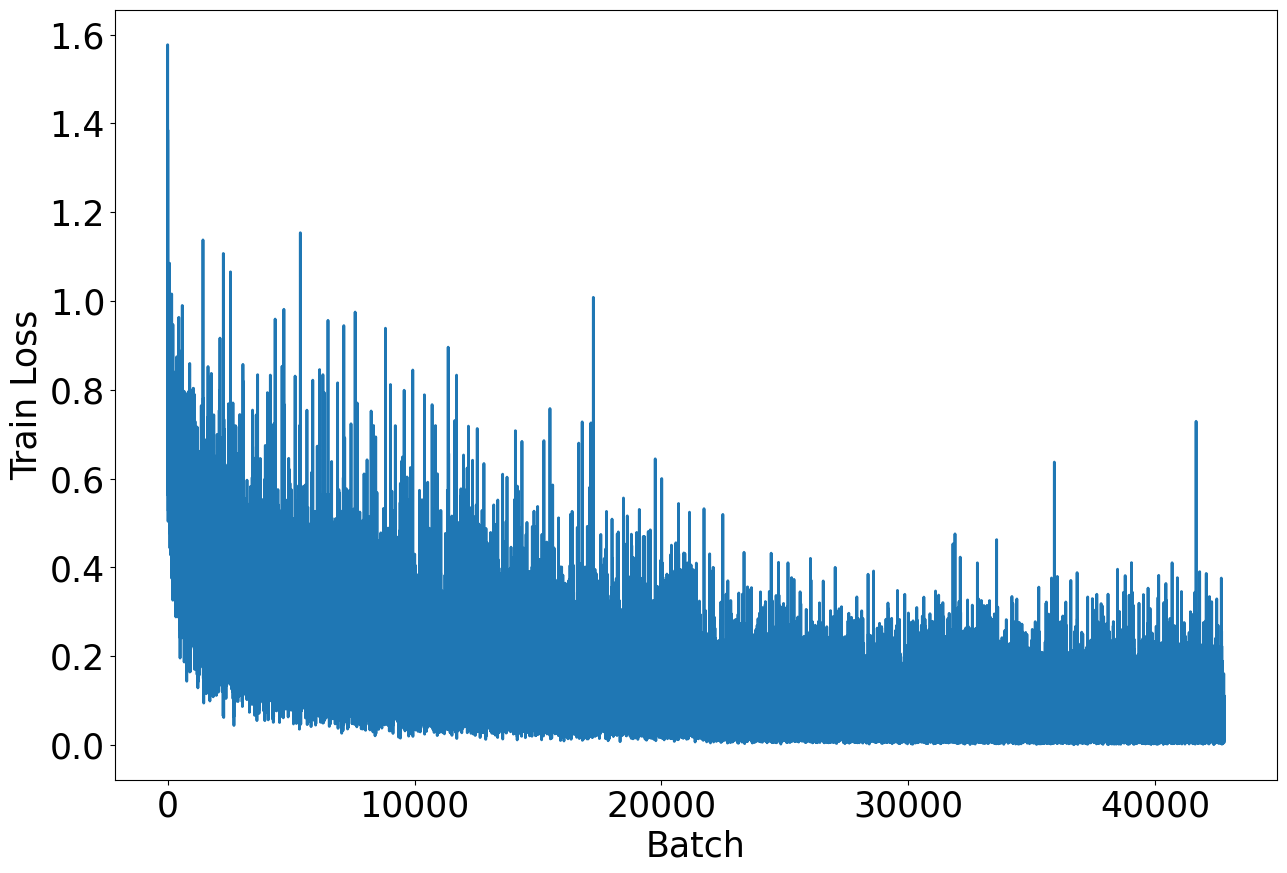

In [71]:
plt.figure(figsize = (15, 10))

x = df_train['batch']
y = df_train['train_loss']

plt.plot(x, y, linewidth = 2)

plt.tick_params(labelsize = 25)
plt.xlabel('Batch', fontsize = 25)
plt.ylabel('Train Loss', fontsize = 25)
# plt.title('train_dataset Loss', fontsize=25)
plt.savefig('figure/train_dataset Loss.tif', dpi = 300, bbox_inches = 'tight')

### `train_dataset` accuracy

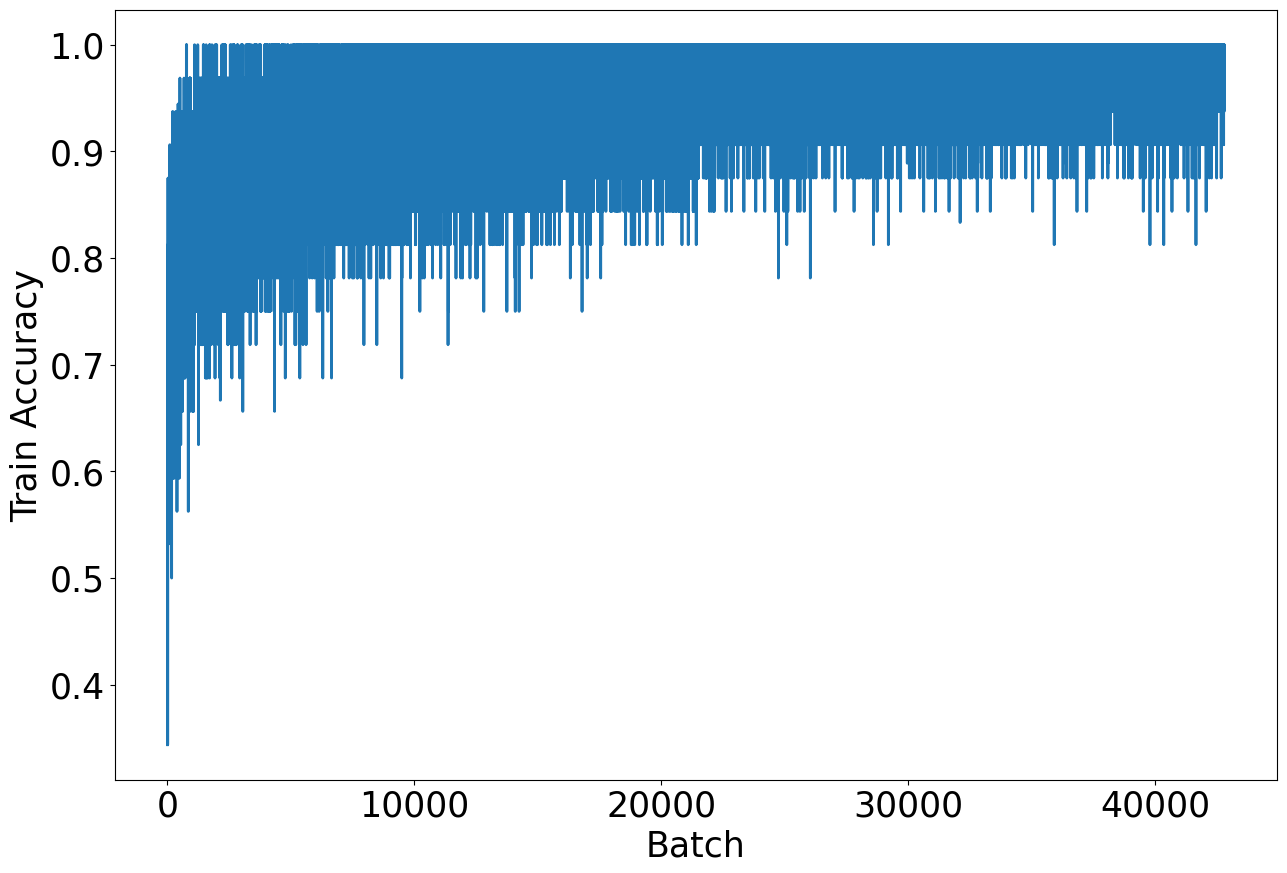

In [72]:
plt.figure(figsize = (15, 10))

x = df_train['batch']
y = df_train['train_accuracy']

plt.plot(x, y, linewidth = 2)

plt.tick_params(labelsize = 25)
plt.xlabel('Batch', fontsize = 25)
plt.ylabel('Train Accuracy', fontsize = 25)
# plt.title('train_dataset Accuracy', fontsize=25)
plt.savefig('figure/train_dataset Accuracy.tif', dpi = 300, bbox_inches = 'tight')

### `test_dataset` loss function

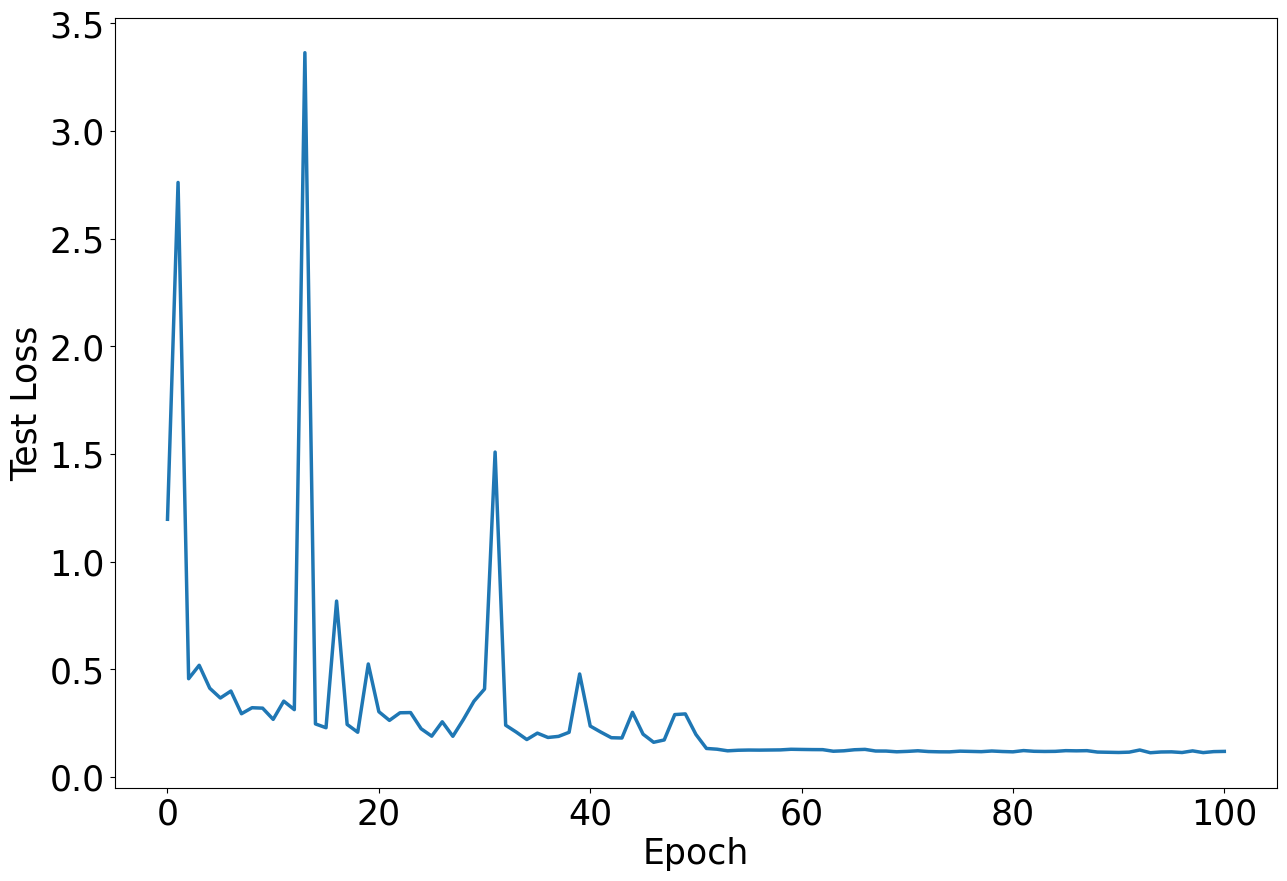

In [73]:
plt.figure(figsize = (15, 10))

x = df_test['epoch']
y = df_test['test_loss']

plt.plot(x, y, linewidth = 2.5)

plt.tick_params(labelsize = 25)
plt.xlabel('Epoch', fontsize = 25)
plt.ylabel('Test Loss', fontsize = 25)
# plt.title('test_dataset Loss', fontsize=25)
plt.savefig('figure/test_dataset Loss.tif', dpi = 300, bbox_inches = 'tight')

### `test_dataset` Metrics

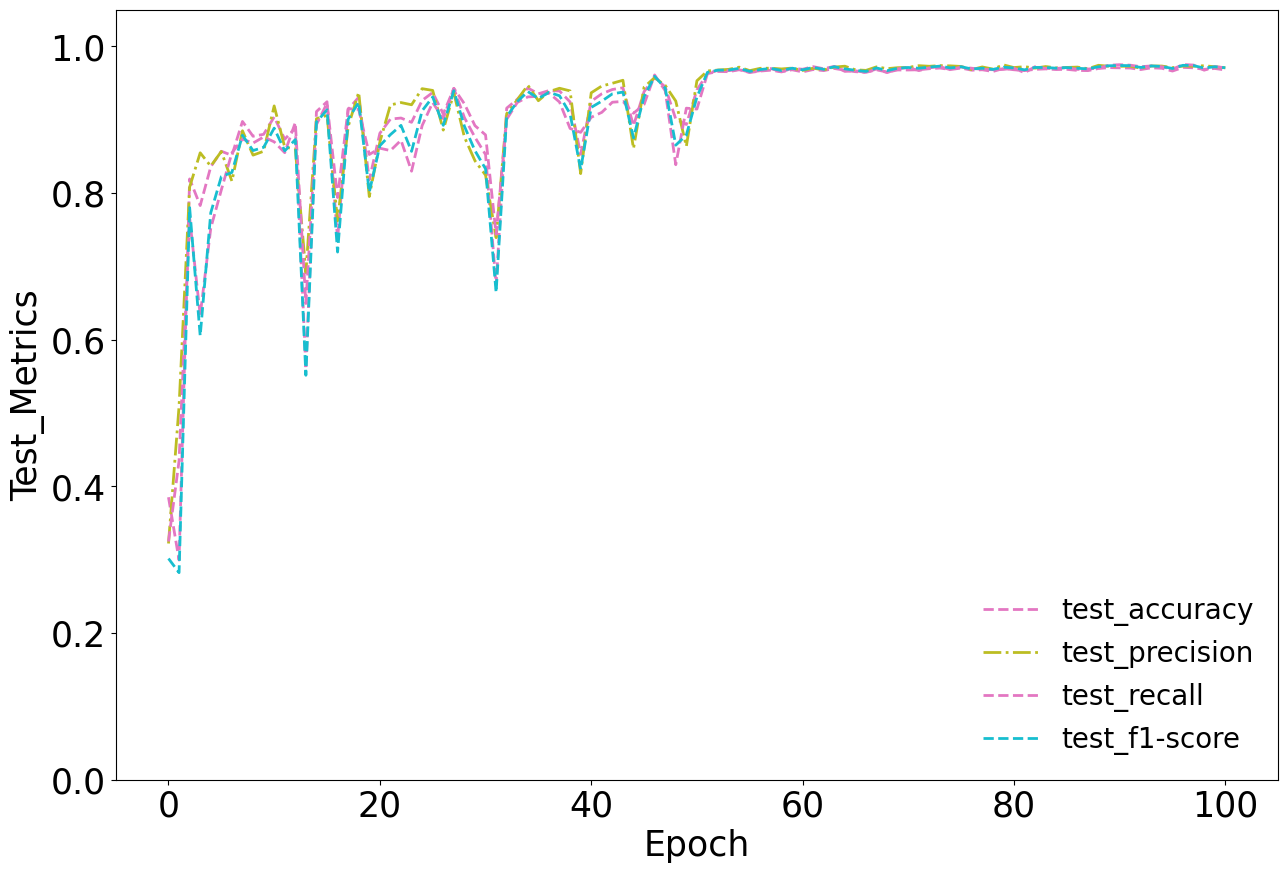

In [74]:
random.seed(222)
colors = ['tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
linestyle = ['--', '-.', '-']

def get_line_arg():
    line_arg = {}
    line_arg['color'] = random.choice(colors)
    line_arg['linestyle'] = random.choice(linestyle)
    line_arg['linewidth'] = 2
    return line_arg

metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1-score']

plt.figure(figsize = (15, 10))

x = df_test['epoch']
for y in metrics:
    plt.plot(x, df_test[y], label = y, **get_line_arg())

plt.tick_params(labelsize = 25)

plt.ylim([0, 1.05])
plt.xlabel('Epoch', fontsize = 25)
plt.ylabel('Test_Metrics', fontsize = 25)
plt.legend(loc = 4, fontsize = 20, frameon = False)
plt.savefig('figure/test_dataset performance.tif', dpi = 300, bbox_inches = 'tight')